# 네이버 검색어 트렌드 복수 단어

## #01. 작업 준비

### 패키지 참조

In [ ]:
import requests
import json
from pandas import DataFrame, to_datetime, merge, melt

import sys
sys.path.append("../../")

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

from helper import set_datetime_index, exp_time_data

### 그래프 한글 설정

In [ ]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 네이버 검색어 트렌드 OpenAPI 연동

### 접속에 필요한 정보 설정

#### API URL

In [ ]:
API_URL = "https://openapi.naver.com/v1/datalab/search"

#### 발급받은 인증키

In [ ]:
client_id = "rETvIsXmOenuP6unjdAz"
client_secret = "z7J2r3pSHd"

### 접속 객체 생성

In [ ]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
})

### 전달할 검색어 구성

In [ ]:
data = {
    "startDate": "2021-07-01",   # 2016년 1월 1일부터 조회 시작 가능
    "endDate": "2023-07-31",
    "timeUnit": "date",         # date: 일간, week: 주간, month: 월간
    "keywordGroups": [
        {
            "groupName": "Benz",  # 검색주제
            "keywords": ["e클래스", "s클래스", "c클래스", "벤츠 cls"]   # 주제와 관련된 검색어
        },
        {
            "groupName": "BMW",  # 검색주제
            "keywords": ["5시리즈", "x5", "x7", "x3"]   # 주제와 관련된 검색어
        },
        {
            "groupName": "AUDI",  # 검색주제
            "keywords": ["a6", "e트론", "a7", "q5"]   # 주제와 관련된 검색어
        }
    ]
}

### 데이터 요청하기

In [ ]:
r = session.post(API_URL, data=json.dumps(data))

if r.status_code != 200:
    msg = "[%d Error] %s 에러가 발생함" % (r.status_code, r.reason)
    raise Exception(msg)

r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2021-07-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': 'Benz',
   'keywords': ['e클래스', 's클래스', 'c클래스', '벤츠 cls'],
   'data': [{'period': '2021-07-01', 'ratio': 27.95718},
    {'period': '2021-07-02', 'ratio': 28.37644},
    {'period': '2021-07-03', 'ratio': 28.90276},
    {'period': '2021-07-04', 'ratio': 28.5727},
    {'period': '2021-07-05', 'ratio': 32.89027},
    {'period': '2021-07-06', 'ratio': 29.07225},
    {'period': '2021-07-07', 'ratio': 28.07314},
    {'period': '2021-07-08', 'ratio': 27.47546},
    {'period': '2021-07-09', 'ratio': 26.57448},
    {'period': '2021-07-10', 'ratio': 29.73238},
    {'period': '2021-07-11', 'ratio': 30.21409},
    {'period': '2021-07-12', 'ratio': 27.9661},
    {'period': '2021-07-13', 'ratio': 29.81266},
    {'period': '2021-07-14', 'ratio': 30.45495},
    {'period': '2021-07-15', 'ratio': 32.31935},
    {'period': '2021-07-16', 'ratio': 35.9322},
    {'period': '2021-07-17', 'ratio': 36.06601},
    {

### 응답 결과 구조

In [ ]:
print("검색 결과 수 :", len(mydict['results']))

검색 결과 수 : 3


In [ ]:
title1 = mydict['results'][0]['title']
print(title1)

data = mydict['results'][0]['data']
df1 = DataFrame(data)
df1.rename(columns={'ratio':title1}, inplace=True)
df1.head()

Benz


,period,Benz
0,2021-07-01,27.95718
1,2021-07-02,28.37644
2,2021-07-03,28.90276
3,2021-07-04,28.57270
4,2021-07-05,32.89027


In [ ]:
title2 = mydict['results'][1]['title']
print(title2)

data = mydict['results'][1]['data']
df2 = DataFrame(data)
df2.rename(columns={'ratio':title2}, inplace=True)
df2.head()

BMW


,period,BMW
0,2021-07-01,44.38001
1,2021-07-02,45.88760
2,2021-07-03,47.01159
3,2021-07-04,46.68153
4,2021-07-05,47.79661


In [ ]:
title3 = mydict['results'][2]['title']
print(title3)

data = mydict['results'][2]['data']
df3 = DataFrame(data)
df3.rename(columns={'ratio':title3}, inplace=True)
df3.head()

AUDI


,period,AUDI
0,2021-07-01,25.38804
1,2021-07-02,27.56467
2,2021-07-03,26.39607
3,2021-07-04,27.27921
4,2021-07-05,28.90276


### 생성된 데이터프레임 병합

In [ ]:
tmp = merge(df1, df2, how='outer')
df = merge(tmp, df3, how='outer')
df.head()

,period,Benz,BMW,AUDI
0,2021-07-01,27.95718,44.38001,25.38804
1,2021-07-02,28.37644,45.88760,27.56467
2,2021-07-03,28.90276,47.01159,26.39607
3,2021-07-04,28.57270,46.68153,27.27921
4,2021-07-05,32.89027,47.79661,28.90276


## #03. 연동 결과에 대한 시계열 분석

### 데이터 타입 확인

In [ ]:
df.dtypes

period     object
Benz      float64
BMW       float64
AUDI      float64
dtype: object

### 날짜 컬럼에 대한 형변환 및 인덱스 설정

In [ ]:
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df, 'period')
df2

,Benz,BMW,AUDI
2021-07-01,27.95718,44.38001,25.38804
2021-07-02,28.37644,45.88760,27.56467
2021-07-03,28.90276,47.01159,26.39607
2021-07-04,28.57270,46.68153,27.27921
2021-07-05,32.89027,47.79661,28.90276
...,...,...,...
2023-07-27,33.31846,61.78412,17.88581
2023-07-28,36.15521,66.67261,19.30419
2023-07-29,36.05709,67.38626,17.71632
2023-07-30,36.82426,67.67172,16.85994


In [ ]:
df3 = df2.reset_index()
df3.head()

,index,Benz,BMW,AUDI
0,2021-07-01,27.95718,44.38001,25.38804
1,2021-07-02,28.37644,45.88760,27.56467
2,2021-07-03,28.90276,47.01159,26.39607
3,2021-07-04,28.57270,46.68153,27.27921
4,2021-07-05,32.89027,47.79661,28.90276


In [ ]:
df4 = melt(df3, id_vars=['index'], value_vars=['Benz','BMW','AUDI'], var_name='키워드', value_name='검색량')
df4.set_index('index', inplace=True)
df4.head()

,키워드,검색량
index,,
2021-07-01,Benz,27.95718
2021-07-02,Benz,28.37644
2021-07-03,Benz,28.90276
2021-07-04,Benz,28.57270
2021-07-05,Benz,32.89027


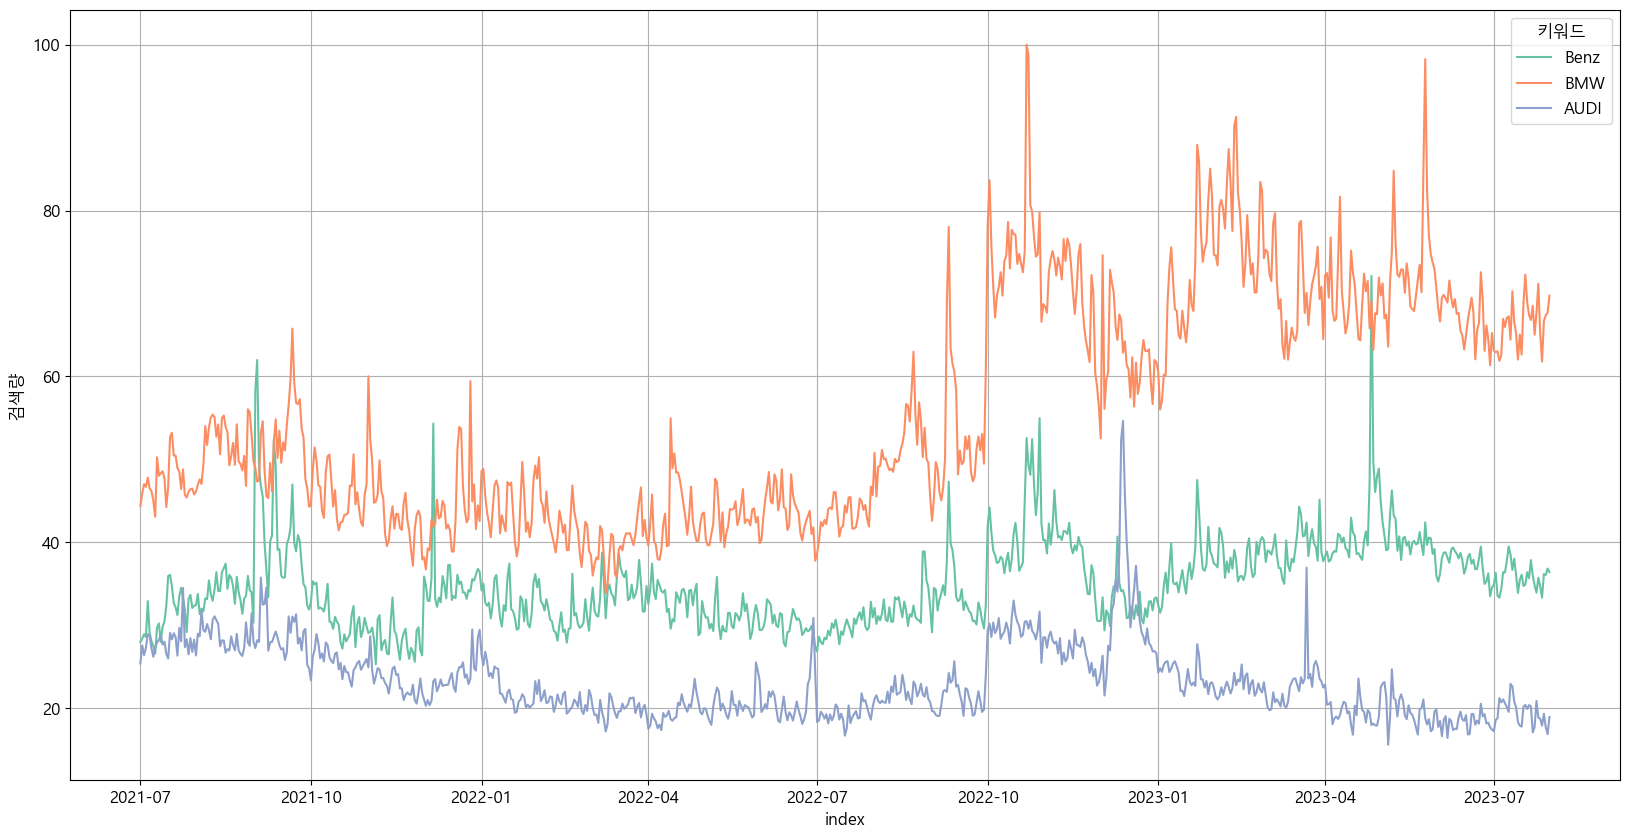

In [ ]:
plt.figure(figsize=(20, 10))
sb.lineplot(data=df4, y='검색량', x=df4.index, hue='키워드', palette='Set2')
plt.grid()
plt.show()
plt.close()

### helper에 구현된 기능을 활용하여 데이터 검정

Benz
결측치 수: 0


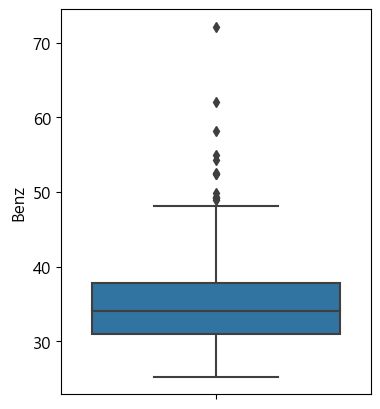

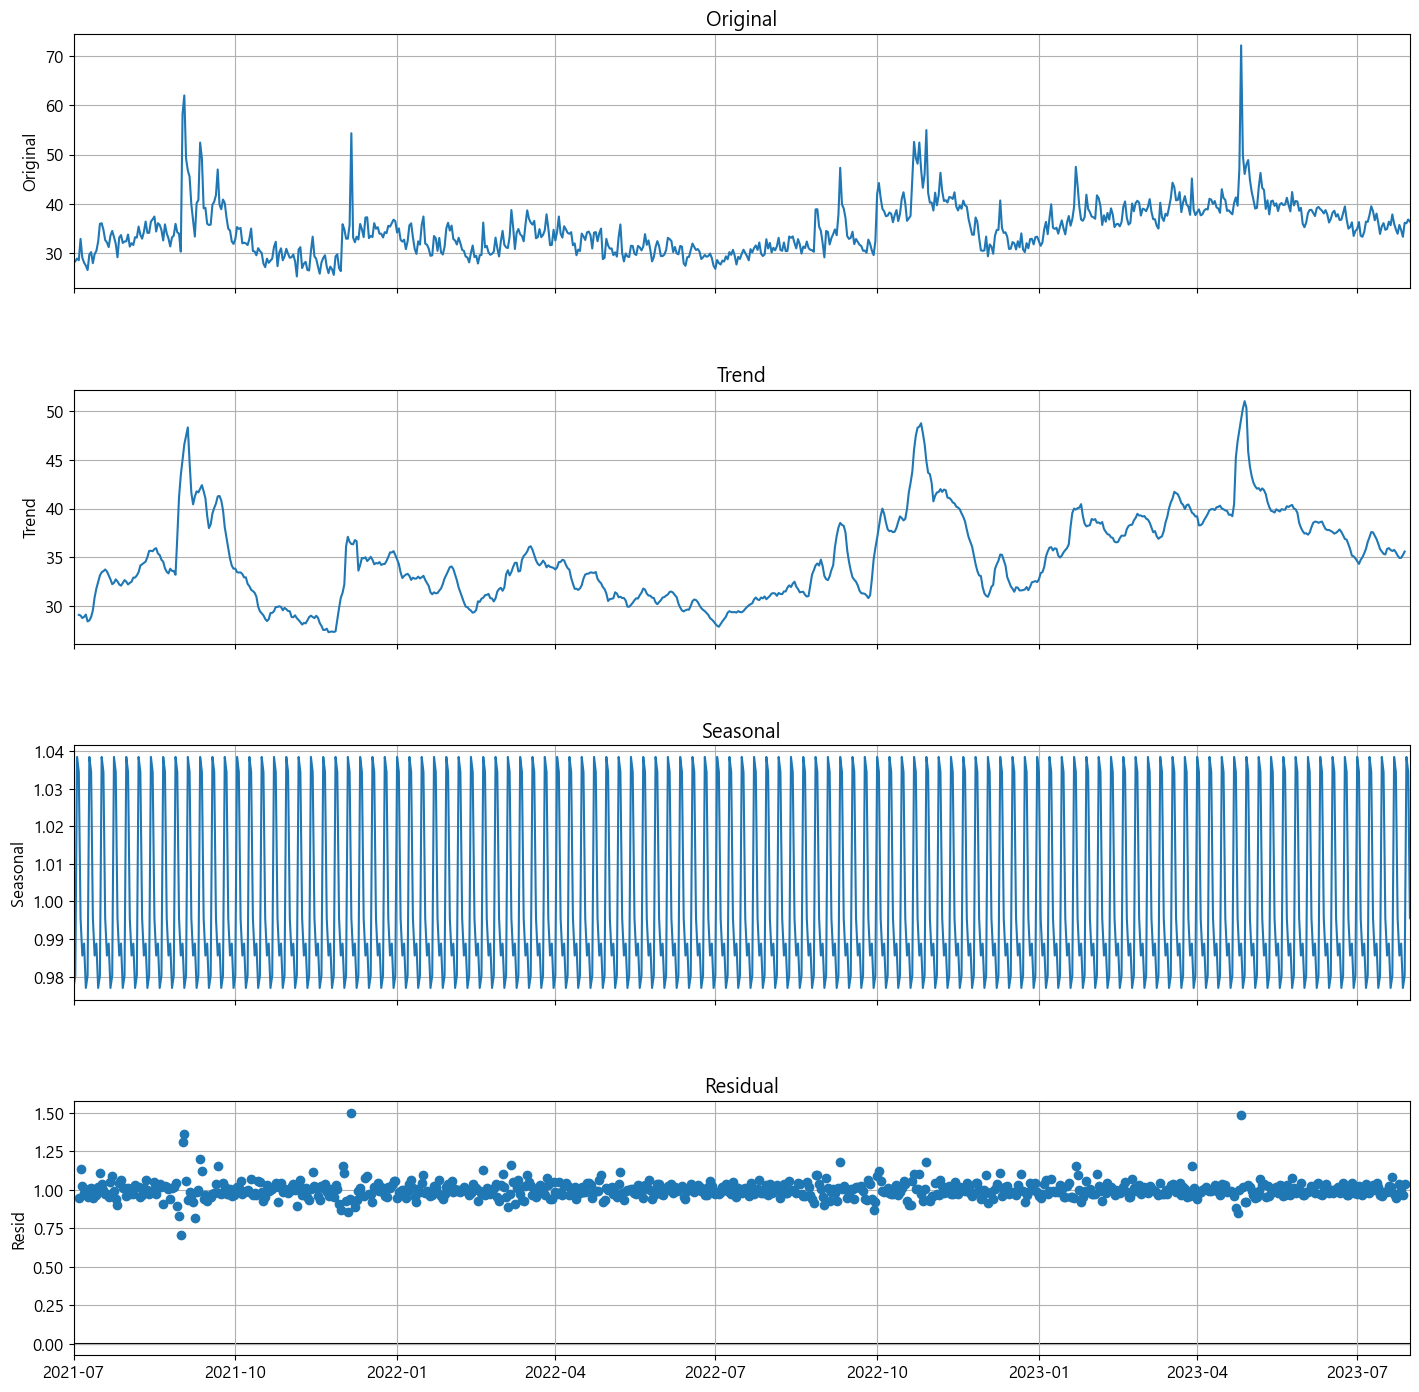

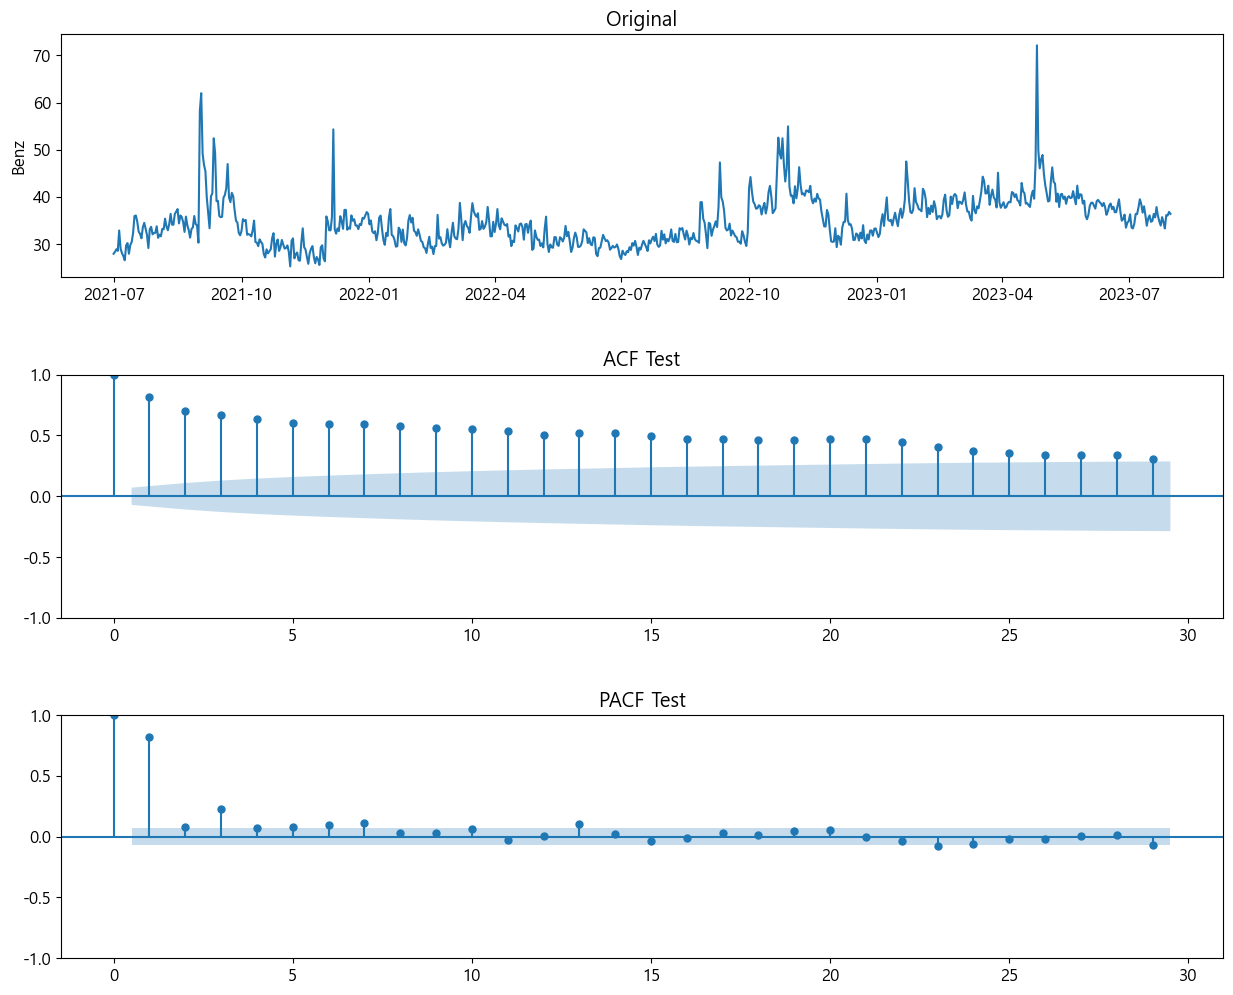

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          |  -3.03839 |
| 유의수준(p-value)                  | 0.0314614 |
| 최적차수(num of lags)              |        12 |
| 관측치 개수(num of observations)   |       748 |
| 기각값(Critical Values) 1%         |  -3.43912 |
| 기각값(Critical Values) 5%         |  -2.86541 |
| 기각값(Critical Values) 10%        |  -2.56883 |
| 데이터 정상성 여부(0=Flase,1=True) |         1 |
+------------------------------------+-----------+
BMW
결측치 수: 0


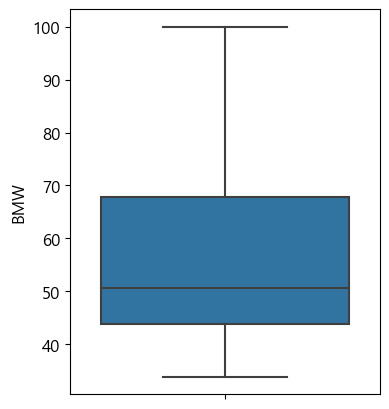

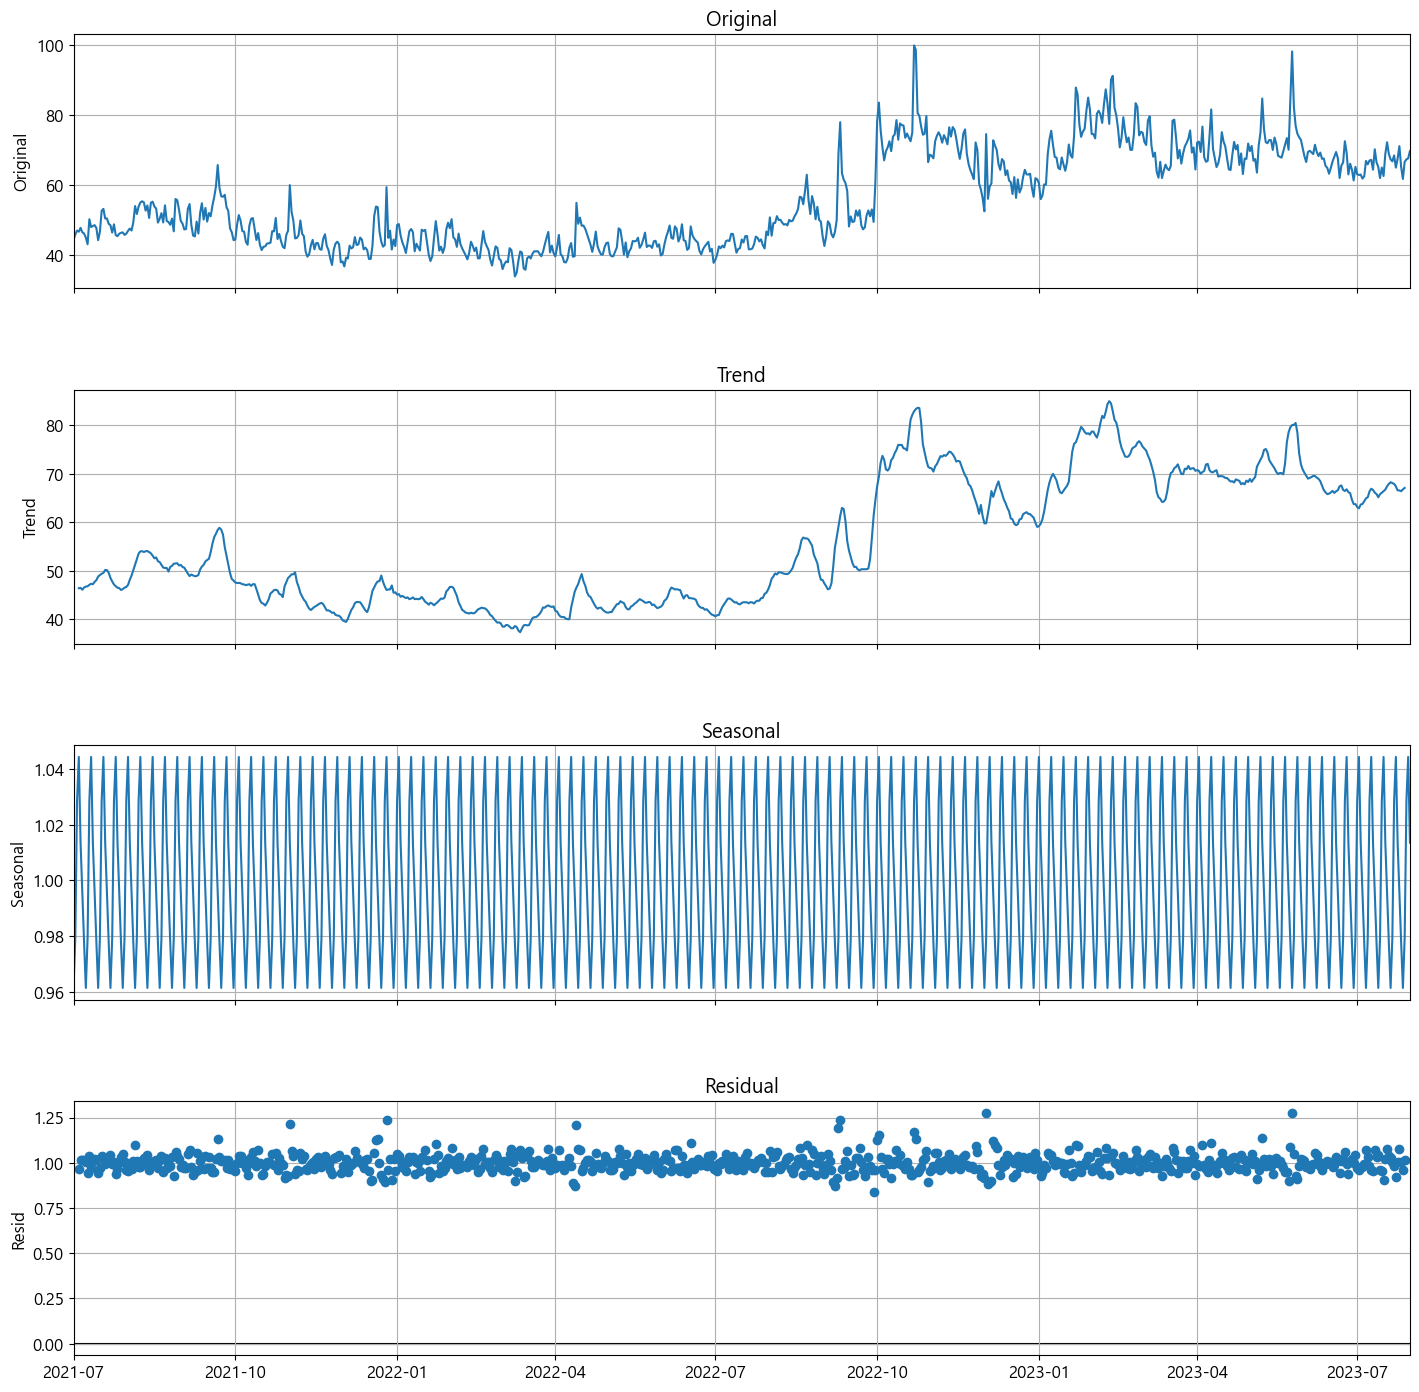

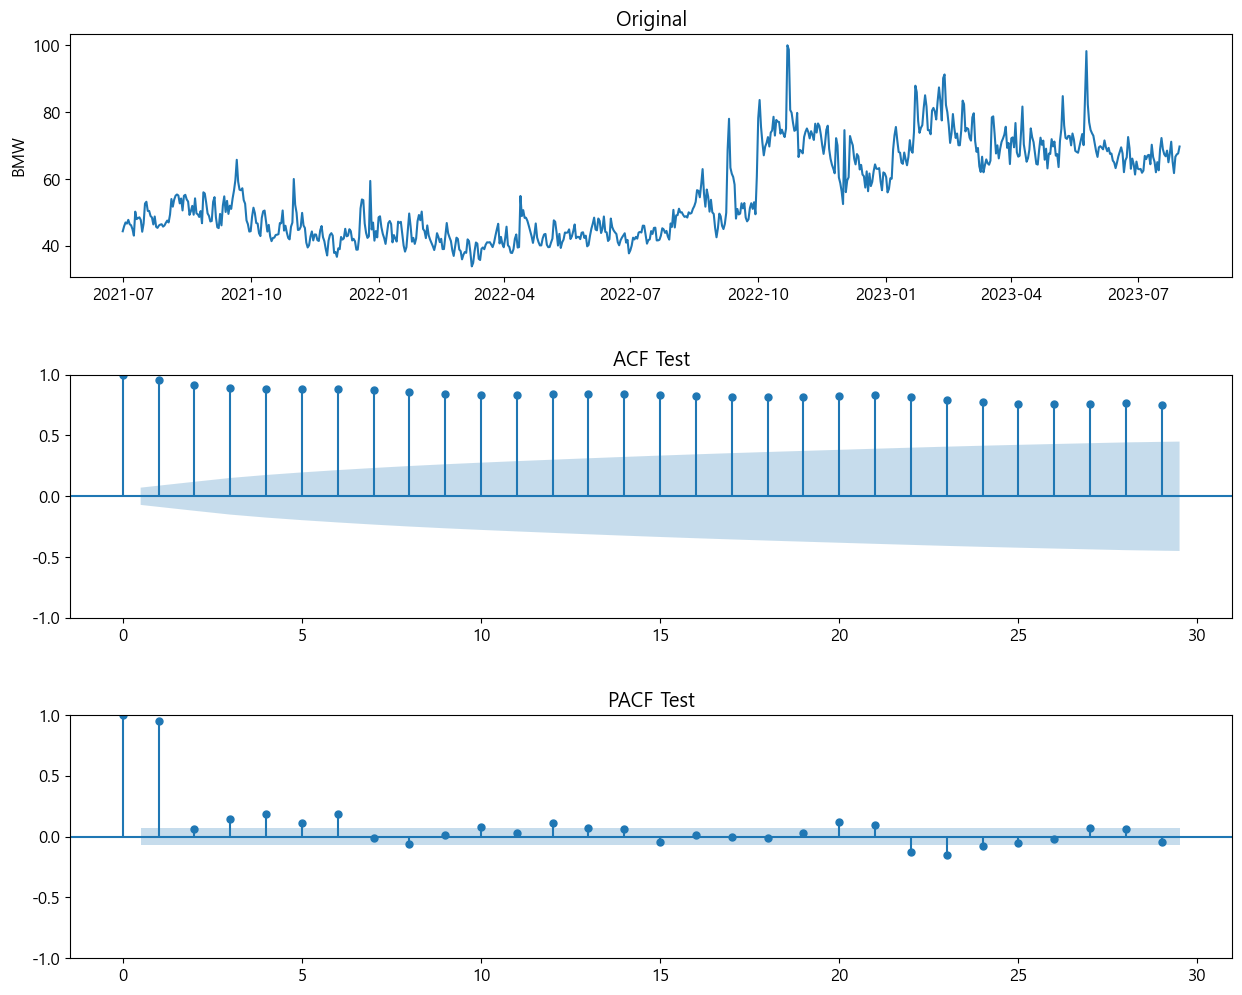

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          | -0.924826 |
| 유의수준(p-value)                  |  0.779687 |
| 최적차수(num of lags)              |        20 |
| 관측치 개수(num of observations)   |       740 |
| 기각값(Critical Values) 1%         |  -3.43922 |
| 기각값(Critical Values) 5%         |  -2.86545 |
| 기각값(Critical Values) 10%        |  -2.56885 |
| 데이터 정상성 여부(0=Flase,1=True) |         0 |
+------------------------------------+-----------+
AUDI
결측치 수: 0


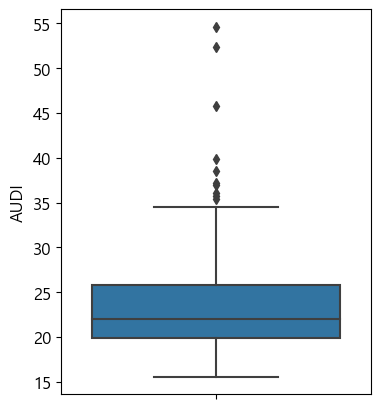

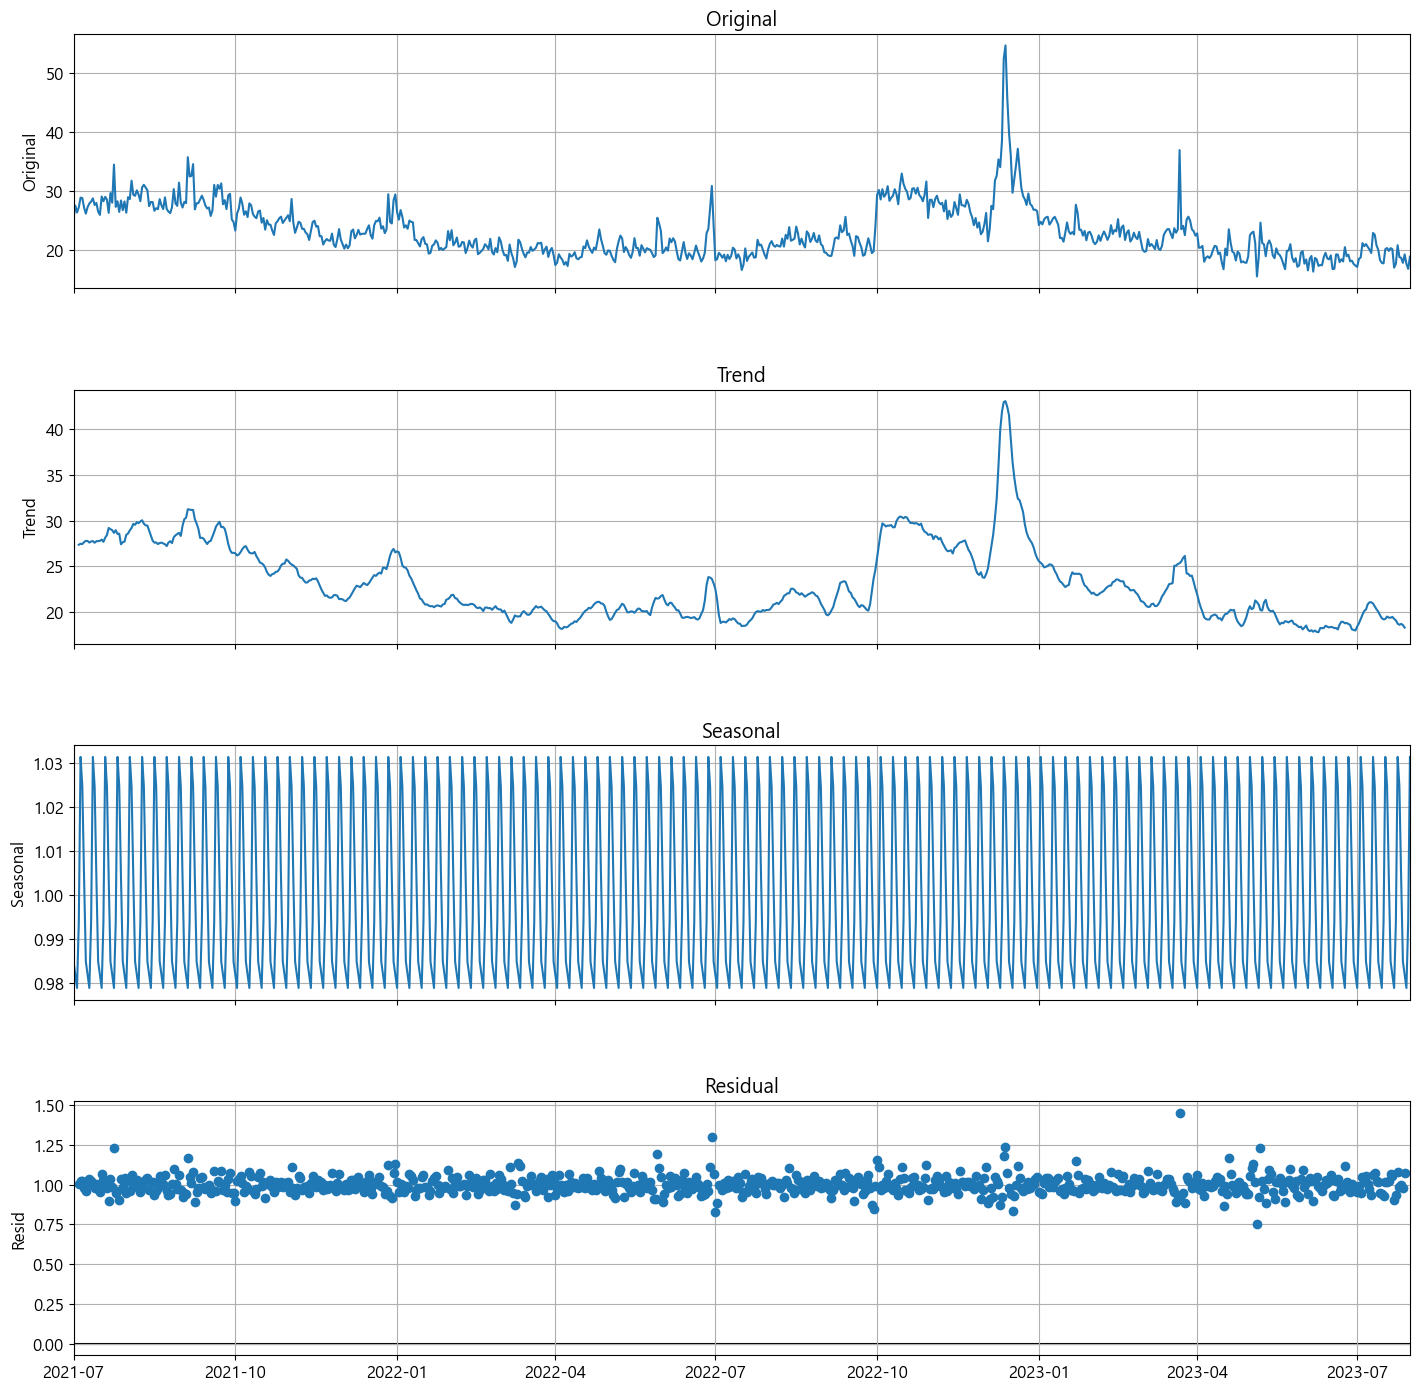

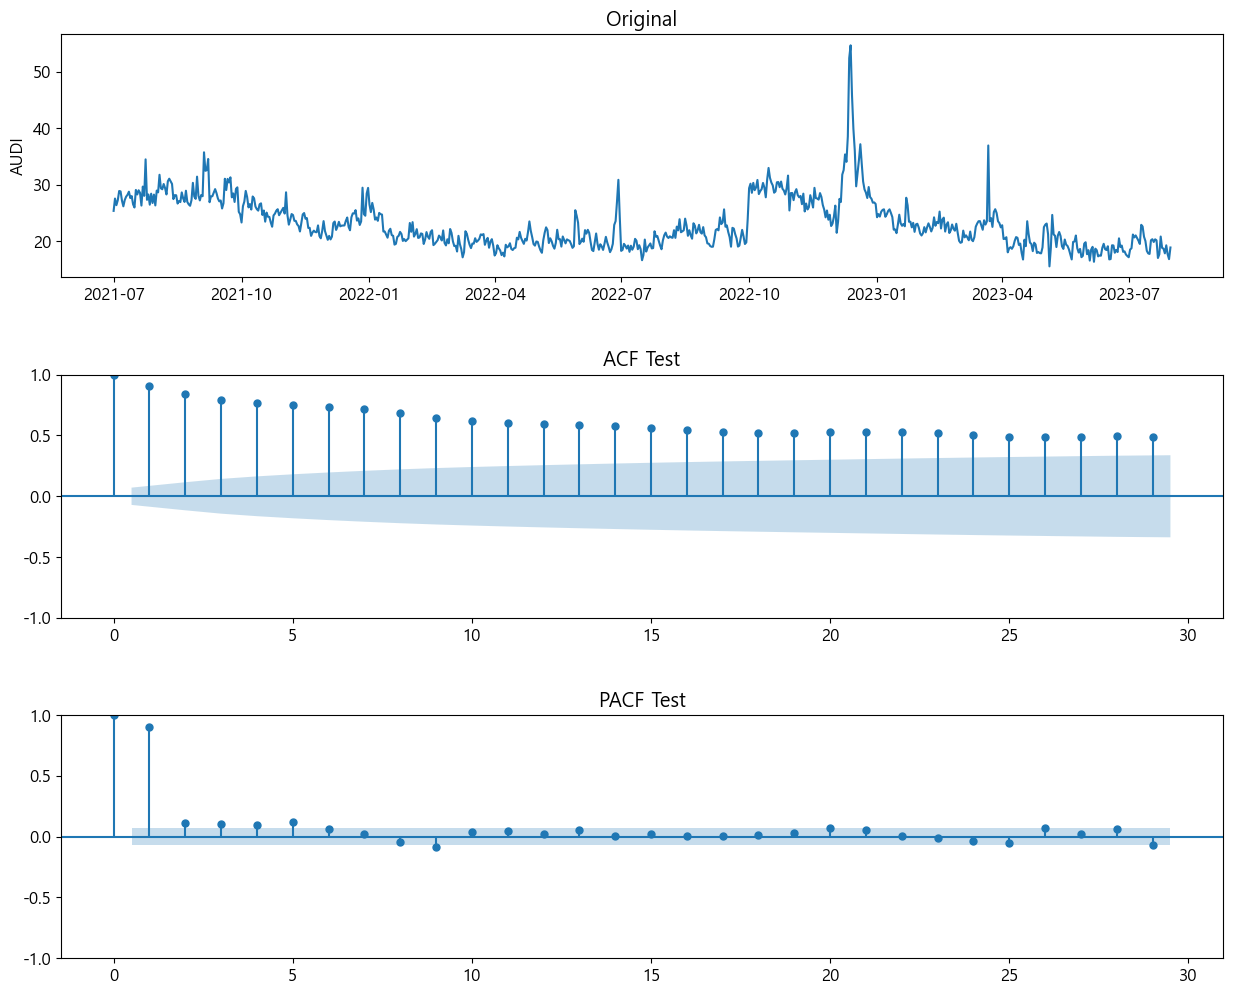

=========== 원본 데이터 ===========
+------------------------------------+------------+
| ADF Test                           |            |
|------------------------------------+------------|
| 검정통계량(ADF Statistic)          |   -3.64569 |
| 유의수준(p-value)                  | 0.00494533 |
| 최적차수(num of lags)              |          8 |
| 관측치 개수(num of observations)   |        752 |
| 기각값(Critical Values) 1%         |   -3.43908 |
| 기각값(Critical Values) 5%         |   -2.86539 |
| 기각값(Critical Values) 10%        |   -2.56882 |
| 데이터 정상성 여부(0=Flase,1=True) |          1 |
+------------------------------------+------------+


In [ ]:
for c in df2.columns:
    print("=========================================")
    print(c)
    print("=========================================")

    exp_time_data(df2, c, "m")

### ARIMA 분석 수행

#### 분석 모델 구성

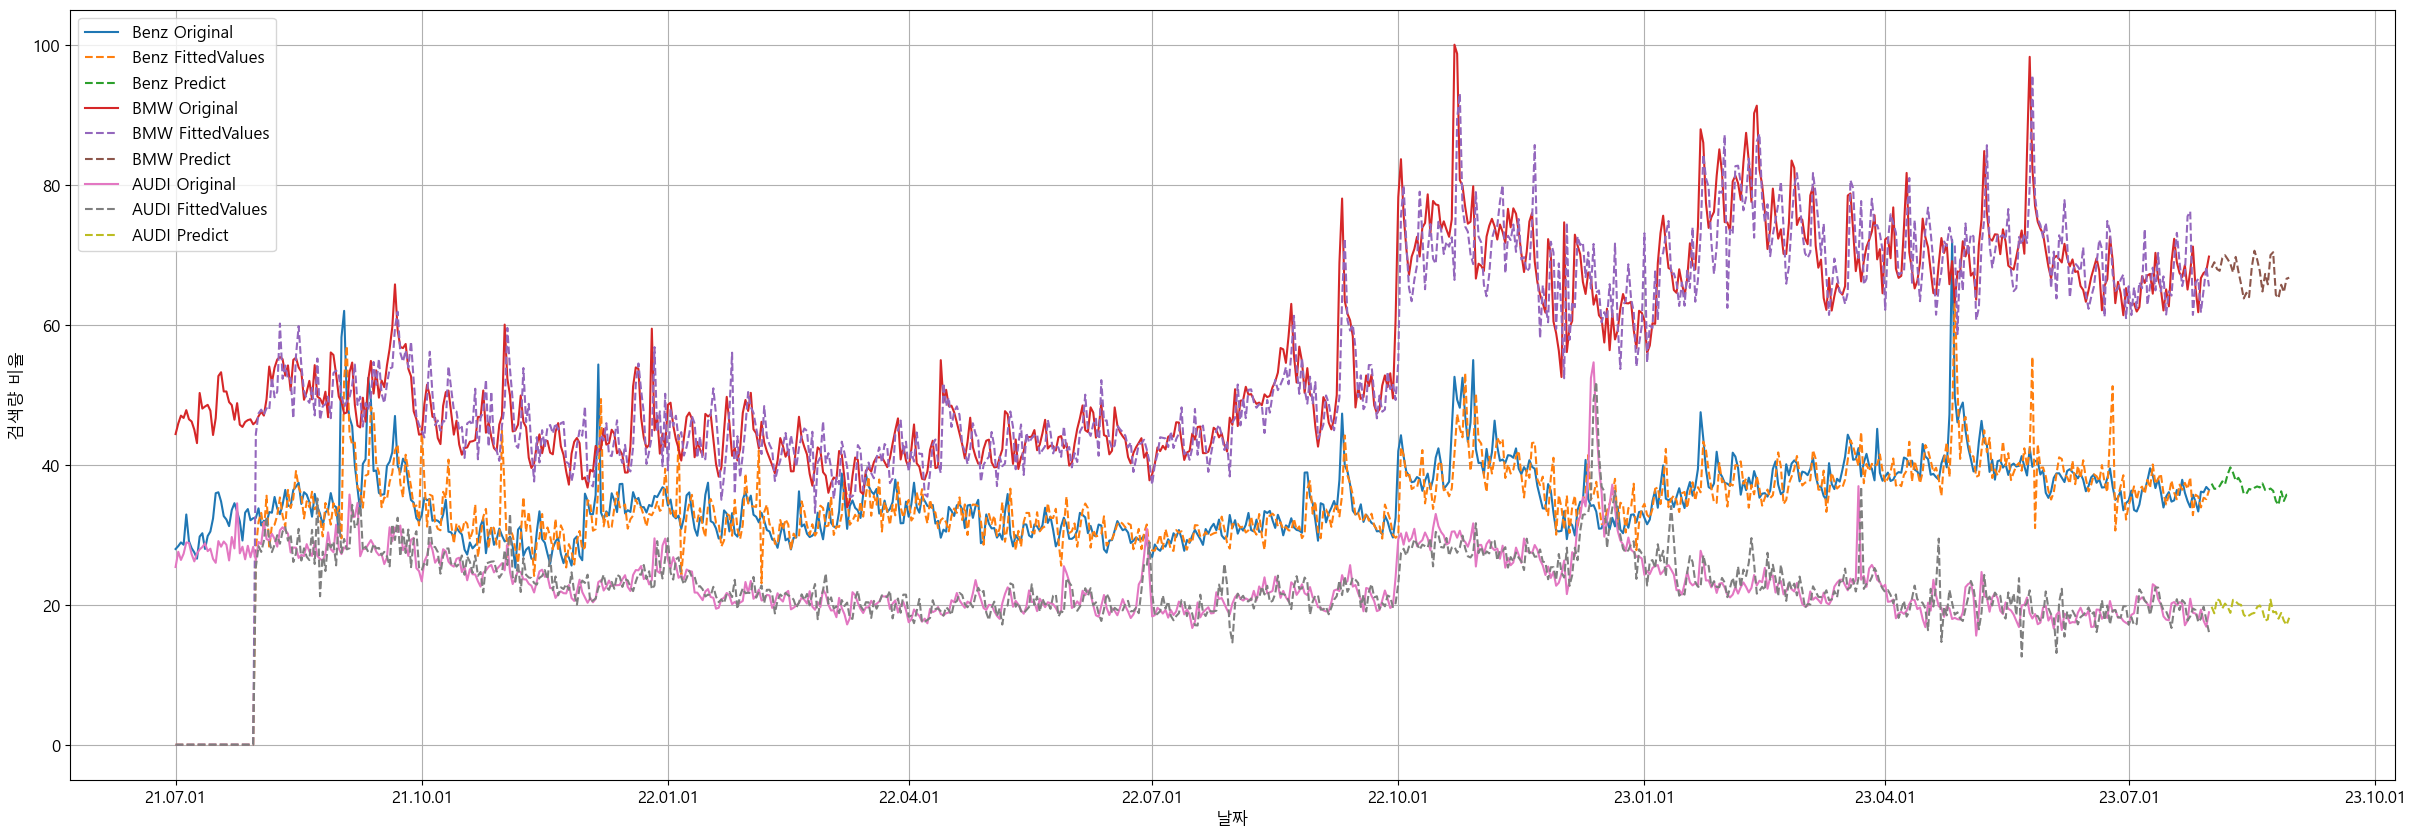